## 1. Load Requiremenets
Import all necessary libraries and load the T5 model and tokenizer from local files. Set up the device for computation.

In [1]:
# Load libraries, input, preprocess, and model
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
try:
    import sentencepiece
except ImportError:
    print("Warning: sentencepiece is not installed. If you encounter tokenizer errors, run: pip install sentencepiece")

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Import helper functions from utils.py
import sys
sys.path.append('./code/utils')
from utils import (
    shuffle_decoder_ffns,
    shuffle_decoder_layers,
    extract_doc_id,
    evaluate_retrieval,
    evaluate_multiple_mlp_shuffles,
    evaluate_multiple_layer_shuffles,
    plot_value_distribution,
    plot_correct_map_heatmap,
    prepare_perms,   
)

# Input and preprocessing
model_path = "./DSI-large-7423"
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare the NQ10k Test Dataset
Load the NQ10k test queries and prepare them as (query, gold_doc_id) pairs for evaluation.

In [2]:
# ---
# Load and Prepare the NQ10k Test Dataset
import json
import os

# Path to the test queries file
nq_test_path = os.path.join("NQ10k", "NQ10k", "test_queries-10000-7423.json")

# Load the test queries
with open(nq_test_path, "r") as f:
    nq_test_data = json.load(f)

# Prepare a list of (query, gold_doc_id) pairs
nq_eval_samples = []
for item in nq_test_data:
    query = item["query"]
    # Use the first relevant doc as the gold doc id, convert to string for comparison
    gold_doc_id = str(item["relevant_docs"][0])
    nq_eval_samples.append((query, gold_doc_id))

print(f"Loaded {len(nq_eval_samples)} test samples from NQ10k.")
# Show a sample
print("Sample:", nq_eval_samples[0])

Loaded 1000 test samples from NQ10k.
Sample: ('what is the name for the ch3coo- ion', '-590834235052106634')


Get statistics about the NQ10k dataset: number of queries per split, number of unique document IDs, and sample queries.

In [3]:
# Number of queries in each split and unique document IDs
import json
import os

splits = [
    ("train", "train_queries-10000-7423.json"),
    ("validation", "val_queries-10000-7423.json"),
    ("test", "test_queries-10000-7423.json")
]

split_stats = {}
unique_doc_ids = set()
for split_name, filename in splits:
    path = os.path.join("NQ10k", "NQ10k", filename)
    with open(path, "r") as f:
        data = json.load(f)
    split_stats[split_name] = len(data)
    for item in data:
        for doc_id in item["relevant_docs"]:
            unique_doc_ids.add(str(doc_id))

print("NQ10k Dataset Statistics:")
for split, count in split_stats.items():
    print(f"  {split.title()} queries: {count}")
print(f"  Unique document IDs (across all splits): {len(unique_doc_ids)}")

# Show a few example queries and their gold doc IDs from the test set
print("\nSample test queries:")
for i in range(3):
    print(f"  Query: {nq_eval_samples[i][0]}")
    print(f"  Gold doc ID: {nq_eval_samples[i][1]}")

NQ10k Dataset Statistics:
  Train queries: 12294
  Validation queries: 1000
  Test queries: 1000
  Unique document IDs (across all splits): 10000

Sample test queries:
  Query: what is the name for the ch3coo- ion
  Gold doc ID: -590834235052106634
  Query: who sang the theme song to the brady bunch
  Gold doc ID: 6224081265211326195
  Query: what does the winner of the rap game get
  Gold doc ID: 8844619839870903


## Shuffling layers

#### Eval After Shuffling
Now evaluate the retrieval accuracy using the model after shuffling the decoder FFNs. Compare the results to the baseline.

In [4]:
# Shuffle decoder FFNs and evaluate again
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval()
acc_before, total, correct = evaluate_retrieval(model, tokenizer, nq_eval_samples, device, verbose=False, limit=50)
print(f"Retrieval accuracy AFTER shuffling: {acc_before:.3f} ({correct}/{total})")

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Retrieval accuracy AFTER shuffling: 0.380 (19/50)


#### Various stages of shuffles

##### All-stage shuffles

In [5]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [True, True, True]  # Shuffle all groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_all_performances, all_shuffles, all_shuffles_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_all_performances)/len(shuffle_all_performances):.3f}")
print("All shuffle accuracies:", shuffle_all_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [18:36<00:00, 11.16s/it]


Average accuracy over 100 shuffles: 0.158
All shuffle accuracies: [0.04, 0.06, 0.36, 0.02, 0.04, 0.38, 0.12, 0.0, 0.12, 0.02, 0.02, 0.22, 0.12, 0.42, 0.2, 0.04, 0.08, 0.3, 0.28, 0.26, 0.04, 0.08, 0.36, 0.38, 0.04, 0.08, 0.32, 0.04, 0.02, 0.3, 0.26, 0.16, 0.24, 0.02, 0.04, 0.02, 0.32, 0.24, 0.14, 0.1, 0.14, 0.3, 0.04, 0.02, 0.02, 0.02, 0.22, 0.12, 0.34, 0.18, 0.02, 0.04, 0.08, 0.26, 0.02, 0.08, 0.32, 0.16, 0.36, 0.02, 0.34, 0.08, 0.0, 0.2, 0.34, 0.36, 0.04, 0.02, 0.36, 0.1, 0.2, 0.08, 0.02, 0.34, 0.22, 0.02, 0.16, 0.32, 0.32, 0.24, 0.02, 0.32, 0.02, 0.28, 0.02, 0.34, 0.24, 0.04, 0.0, 0.32, 0.04, 0.36, 0.3, 0.06, 0.22, 0.02, 0.02, 0.02, 0.08, 0.3]


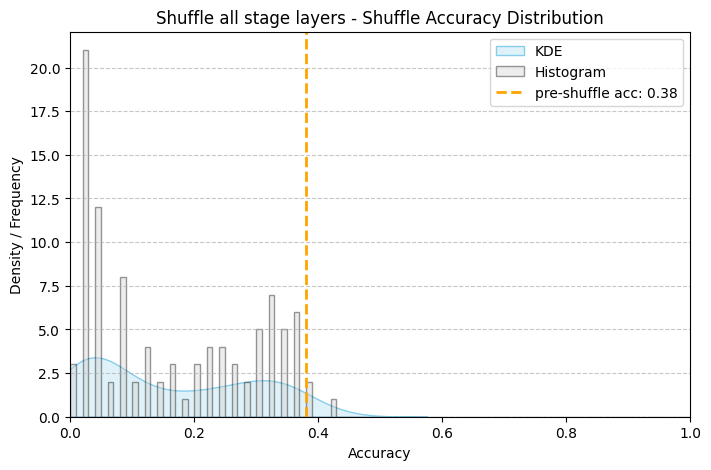

In [6]:
plot_value_distribution(shuffle_all_performances, special_value=acc_before, title="Shuffle all stage layers")

##### All-stage shuffles exluding last layers

In [7]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [True, True, True]  # Shuffle all groups; change as needed
exclude_last_layer = [True, True, True]  # exlusion of last layer in groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_all_performances, all_shuffles, all_shuffles_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    exclude_last_layer=exclude_last_layer,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_all_performances)/len(shuffle_all_performances):.3f}")
print("All shuffle accuracies:", shuffle_all_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [18:19<00:00, 10.99s/it]


Average accuracy over 100 shuffles: 0.204
All shuffle accuracies: [0.38, 0.38, 0.32, 0.04, 0.32, 0.04, 0.3, 0.02, 0.1, 0.02, 0.12, 0.12, 0.28, 0.06, 0.02, 0.32, 0.12, 0.38, 0.02, 0.12, 0.32, 0.38, 0.12, 0.02, 0.04, 0.3, 0.06, 0.4, 0.3, 0.04, 0.42, 0.06, 0.12, 0.04, 0.04, 0.36, 0.12, 0.04, 0.02, 0.32, 0.38, 0.4, 0.3, 0.4, 0.26, 0.3, 0.02, 0.32, 0.3, 0.04, 0.36, 0.04, 0.28, 0.02, 0.12, 0.38, 0.38, 0.4, 0.38, 0.02, 0.38, 0.04, 0.02, 0.36, 0.38, 0.28, 0.32, 0.06, 0.4, 0.06, 0.12, 0.04, 0.32, 0.04, 0.04, 0.4, 0.12, 0.34, 0.02, 0.36, 0.34, 0.04, 0.34, 0.34, 0.02, 0.04, 0.3, 0.02, 0.32, 0.38, 0.34, 0.32, 0.36, 0.04, 0.12, 0.38, 0.02, 0.12, 0.04, 0.32]


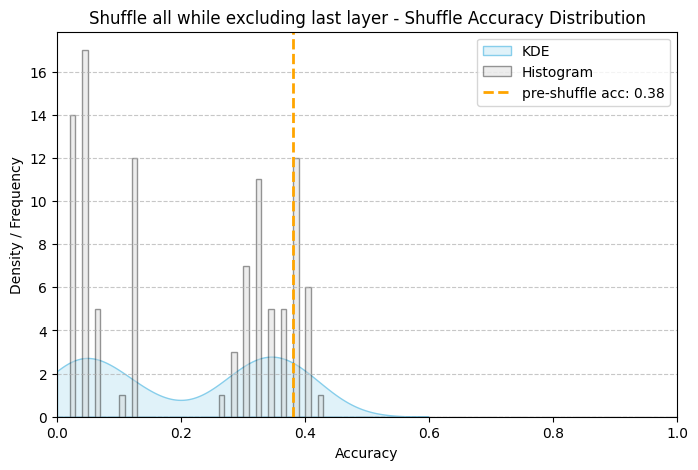

In [8]:
plot_value_distribution(shuffle_all_performances, special_value=acc_before, title="Shuffle all while excluding last layer")

##### Stage-3 shuffles

In [9]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [False, False, True]  # Shuffle all groups; change as needed
limit = 50  # NNumber of samples to evaluate for speed

shuffle_stage3_performances, stage3_shuffles, stage3_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage3_performances)/len(shuffle_stage3_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage3_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


Average accuracy over 100 shuffles: 0.314
All shuffle accuracies: [0.26, 0.32, 0.36, 0.36, 0.38, 0.38, 0.38, 0.38, 0.28, 0.22, 0.24, 0.3, 0.18, 0.32, 0.36, 0.24, 0.42, 0.36, 0.32, 0.24, 0.32, 0.28, 0.2, 0.2, 0.38, 0.22, 0.32, 0.16, 0.38, 0.24, 0.32, 0.34, 0.36, 0.38, 0.34, 0.32, 0.28, 0.3, 0.34, 0.36, 0.34, 0.36, 0.42, 0.26, 0.42, 0.18, 0.34, 0.4, 0.28, 0.16, 0.42, 0.22, 0.38, 0.26, 0.26, 0.4, 0.32, 0.2, 0.38, 0.3, 0.42, 0.24, 0.36, 0.26, 0.38, 0.42, 0.3, 0.3, 0.24, 0.36, 0.18, 0.3, 0.36, 0.36, 0.26, 0.26, 0.28, 0.16, 0.36, 0.34, 0.38, 0.36, 0.26, 0.36, 0.4, 0.42, 0.36, 0.36, 0.28, 0.18, 0.42, 0.24, 0.36, 0.26, 0.38, 0.24, 0.36, 0.2, 0.36, 0.4]


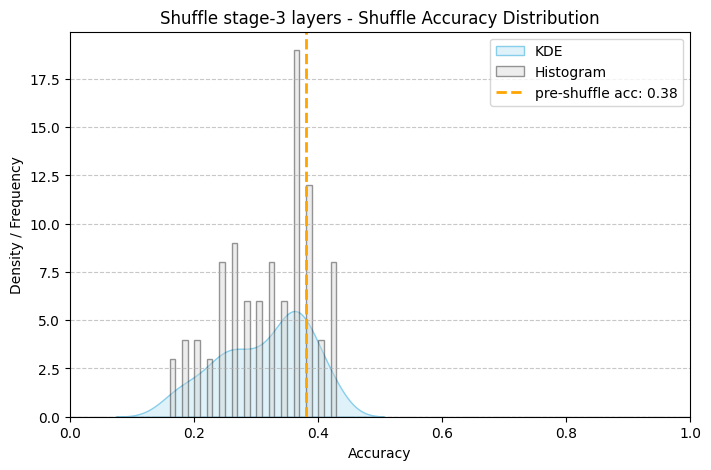

In [10]:
plot_value_distribution(shuffle_stage3_performances, special_value=acc_before, title="Shuffle stage-3 layers")

##### Stage-3 shuffles excluding last layer 

In [11]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [False, False, True]  # Shuffle all groups; change as needed
exclude_last_layer = [False, False, True]  # exlusion of last layer in groups; change as needed
limit = 50  # NNumber of samples to evaluate for speed

shuffle_stage3_ex_last_performances, stage3_shuffles_ex_last, stage3_correct_maps_ex_last = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    exclude_last_layer=exclude_last_layer,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage3_ex_last_performances)/len(shuffle_stage3_ex_last_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage3_ex_last_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


Average accuracy over 100 shuffles: 0.381
All shuffle accuracies: [0.34, 0.4, 0.4, 0.36, 0.32, 0.4, 0.34, 0.38, 0.38, 0.38, 0.42, 0.34, 0.36, 0.4, 0.42, 0.36, 0.36, 0.36, 0.34, 0.42, 0.42, 0.38, 0.4, 0.4, 0.38, 0.34, 0.38, 0.36, 0.36, 0.42, 0.32, 0.38, 0.38, 0.38, 0.4, 0.42, 0.36, 0.36, 0.38, 0.34, 0.36, 0.42, 0.4, 0.38, 0.42, 0.4, 0.4, 0.36, 0.36, 0.42, 0.4, 0.4, 0.34, 0.36, 0.42, 0.38, 0.4, 0.38, 0.4, 0.4, 0.4, 0.34, 0.36, 0.4, 0.36, 0.4, 0.42, 0.38, 0.4, 0.38, 0.38, 0.36, 0.4, 0.4, 0.36, 0.4, 0.42, 0.42, 0.38, 0.38, 0.32, 0.4, 0.36, 0.38, 0.36, 0.34, 0.36, 0.36, 0.36, 0.36, 0.38, 0.38, 0.38, 0.38, 0.4, 0.4, 0.42, 0.4, 0.4, 0.38]


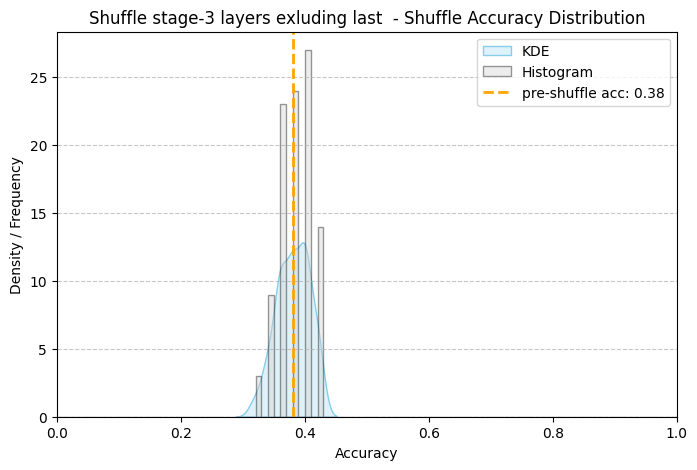

In [12]:
plot_value_distribution(shuffle_stage3_ex_last_performances, special_value=acc_before, title="Shuffle stage-3 layers exluding last ")

In [13]:
stage3_shuffles_ex_last

[[[], [], [22, 19, 20, 18, 21, 23]],
 [[], [], [20, 18, 19, 21, 22, 23]],
 [[], [], [19, 21, 20, 18, 22, 23]],
 [[], [], [22, 20, 21, 19, 18, 23]],
 [[], [], [22, 20, 19, 18, 21, 23]],
 [[], [], [18, 21, 22, 19, 20, 23]],
 [[], [], [22, 21, 19, 18, 20, 23]],
 [[], [], [22, 21, 19, 20, 18, 23]],
 [[], [], [19, 18, 21, 22, 20, 23]],
 [[], [], [21, 22, 19, 18, 20, 23]],
 [[], [], [20, 21, 22, 18, 19, 23]],
 [[], [], [22, 19, 18, 21, 20, 23]],
 [[], [], [22, 21, 18, 19, 20, 23]],
 [[], [], [21, 19, 18, 22, 20, 23]],
 [[], [], [21, 20, 18, 19, 22, 23]],
 [[], [], [19, 18, 22, 21, 20, 23]],
 [[], [], [19, 22, 21, 18, 20, 23]],
 [[], [], [22, 21, 18, 20, 19, 23]],
 [[], [], [22, 19, 18, 21, 20, 23]],
 [[], [], [18, 19, 21, 20, 22, 23]],
 [[], [], [18, 21, 20, 19, 22, 23]],
 [[], [], [19, 18, 20, 22, 21, 23]],
 [[], [], [21, 19, 18, 22, 20, 23]],
 [[], [], [21, 20, 19, 22, 18, 23]],
 [[], [], [20, 19, 18, 22, 21, 23]],
 [[], [], [22, 21, 19, 18, 20, 23]],
 [[], [], [22, 18, 21, 19, 20, 23]],
 

##### Stage-2 shuffles

In [14]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [False, True, False]  # Shuffle all groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_stage2_performances, stage2_shuffles, stage2_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage2_performances)/len(shuffle_stage2_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage2_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


Average accuracy over 100 shuffles: 0.389
All shuffle accuracies: [0.4, 0.38, 0.4, 0.4, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.4, 0.38, 0.38, 0.4, 0.38, 0.4, 0.38, 0.4, 0.42, 0.38, 0.42, 0.4, 0.4, 0.42, 0.4, 0.34, 0.4, 0.4, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.4, 0.4, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.38, 0.4, 0.38, 0.34, 0.36, 0.38, 0.4, 0.4, 0.38, 0.4, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.38, 0.38, 0.38, 0.38, 0.4, 0.38, 0.4, 0.38, 0.4, 0.38, 0.38, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.38, 0.38, 0.42, 0.4, 0.38, 0.38, 0.4, 0.38, 0.36, 0.4, 0.38, 0.38, 0.38, 0.38, 0.4, 0.4, 0.4, 0.38, 0.4, 0.38, 0.38, 0.4]


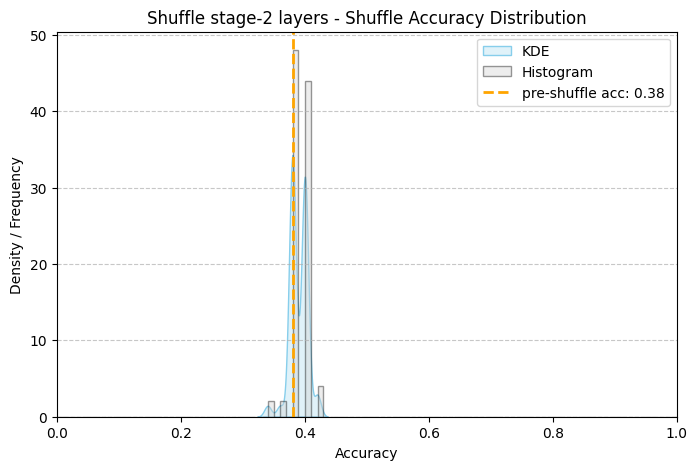

In [15]:
plot_value_distribution(shuffle_stage2_performances, special_value=acc_before, title="Shuffle stage-2 layers")

In [16]:
stage2_shuffles

[[[], [9, 8, 14, 15, 11, 7, 16, 17, 12, 10, 13], []],
 [[], [7, 17, 8, 12, 16, 13, 14, 15, 9, 10, 11], []],
 [[], [10, 17, 15, 11, 14, 12, 16, 13, 7, 8, 9], []],
 [[], [11, 15, 13, 16, 8, 14, 10, 17, 9, 12, 7], []],
 [[], [7, 8, 16, 12, 15, 9, 17, 10, 14, 11, 13], []],
 [[], [9, 11, 14, 8, 13, 10, 12, 15, 7, 16, 17], []],
 [[], [12, 11, 8, 17, 16, 7, 13, 9, 14, 10, 15], []],
 [[], [12, 15, 17, 16, 13, 14, 9, 7, 11, 10, 8], []],
 [[], [9, 16, 14, 10, 15, 11, 17, 8, 7, 13, 12], []],
 [[], [14, 15, 7, 9, 8, 13, 11, 12, 17, 10, 16], []],
 [[], [14, 11, 15, 8, 10, 13, 9, 16, 17, 7, 12], []],
 [[], [9, 11, 17, 12, 13, 7, 14, 8, 16, 10, 15], []],
 [[], [12, 15, 7, 10, 16, 8, 11, 13, 17, 14, 9], []],
 [[], [14, 9, 16, 7, 8, 15, 17, 10, 12, 13, 11], []],
 [[], [14, 8, 17, 15, 10, 11, 16, 12, 7, 9, 13], []],
 [[], [9, 13, 7, 16, 11, 10, 14, 8, 12, 15, 17], []],
 [[], [14, 12, 9, 7, 15, 10, 17, 13, 8, 16, 11], []],
 [[], [9, 15, 7, 10, 17, 12, 13, 14, 8, 11, 16], []],
 [[], [12, 7, 14, 13, 11, 16

##### Stage-2 shuffles excluding last layer

In [17]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [False, True, False]  # Shuffle all groups; change as needed
exclude_last_layer = [False, True, False]  # exlusion of last layer in groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_stage2_performances, stage2_shuffles, stage2_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    exclude_last_layer=exclude_last_layer,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage2_performances)/len(shuffle_stage2_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage2_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


Average accuracy over 100 shuffles: 0.393
All shuffle accuracies: [0.38, 0.4, 0.4, 0.38, 0.4, 0.4, 0.4, 0.38, 0.4, 0.4, 0.36, 0.38, 0.4, 0.4, 0.4, 0.4, 0.4, 0.38, 0.4, 0.38, 0.38, 0.4, 0.42, 0.38, 0.38, 0.4, 0.4, 0.4, 0.38, 0.4, 0.42, 0.38, 0.38, 0.4, 0.38, 0.38, 0.4, 0.4, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.38, 0.4, 0.4, 0.4, 0.38, 0.38, 0.38, 0.4, 0.38, 0.42, 0.38, 0.4, 0.38, 0.4, 0.38, 0.42, 0.4, 0.38, 0.4, 0.38, 0.4, 0.38, 0.38, 0.4, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.4, 0.4, 0.4, 0.42, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.38, 0.38, 0.38, 0.38, 0.4, 0.4, 0.4, 0.38, 0.42, 0.4, 0.38, 0.42, 0.4, 0.4, 0.4, 0.4]


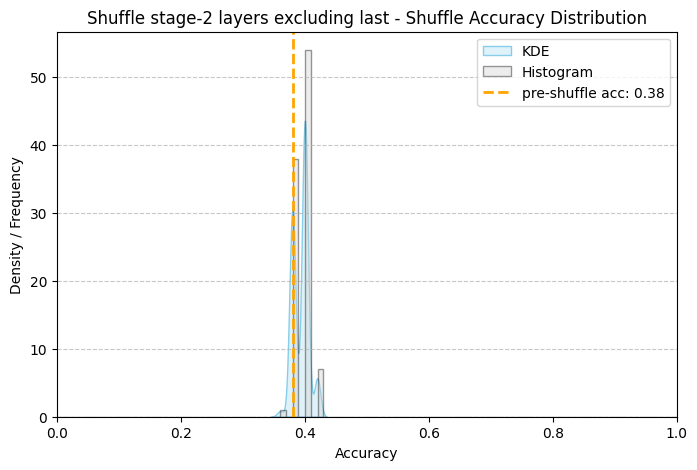

In [18]:
plot_value_distribution(shuffle_stage2_performances, special_value=acc_before, title="Shuffle stage-2 layers excluding last")

In [19]:
stage2_shuffles

[[[], [12, 16, 8, 14, 15, 10, 11, 13, 7, 9, 17], []],
 [[], [14, 15, 12, 13, 9, 11, 10, 7, 8, 16, 17], []],
 [[], [13, 8, 16, 9, 15, 11, 14, 7, 10, 12, 17], []],
 [[], [15, 12, 11, 16, 14, 10, 13, 8, 7, 9, 17], []],
 [[], [15, 12, 10, 14, 13, 11, 8, 9, 7, 16, 17], []],
 [[], [13, 10, 14, 8, 12, 16, 15, 9, 11, 7, 17], []],
 [[], [12, 9, 13, 14, 15, 8, 10, 11, 7, 16, 17], []],
 [[], [12, 9, 11, 8, 10, 13, 16, 14, 7, 15, 17], []],
 [[], [12, 9, 14, 16, 15, 10, 7, 13, 8, 11, 17], []],
 [[], [13, 8, 15, 16, 14, 12, 9, 7, 10, 11, 17], []],
 [[], [9, 16, 12, 10, 7, 15, 11, 8, 13, 14, 17], []],
 [[], [15, 16, 9, 8, 11, 10, 7, 14, 13, 12, 17], []],
 [[], [7, 13, 16, 11, 15, 9, 10, 8, 14, 12, 17], []],
 [[], [7, 8, 12, 9, 13, 16, 10, 15, 11, 14, 17], []],
 [[], [13, 16, 7, 12, 15, 9, 8, 14, 11, 10, 17], []],
 [[], [14, 12, 7, 15, 10, 11, 9, 16, 8, 13, 17], []],
 [[], [12, 13, 15, 11, 8, 7, 14, 10, 9, 16, 17], []],
 [[], [9, 13, 12, 16, 8, 14, 11, 7, 15, 10, 17], []],
 [[], [10, 7, 14, 12, 8, 15,

##### Stage-1 shuffles

In [5]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [True, False, False]  # Shuffle all groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_stage1_performances, stage1_shuffles, stage1_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage1_performances)/len(shuffle_stage1_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage1_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 100/100 [30:19<00:00, 18.19s/it]


Average accuracy over 100 shuffles: 0.216
All shuffle accuracies: [0.06, 0.12, 0.06, 0.12, 0.38, 0.06, 0.02, 0.32, 0.42, 0.18, 0.04, 0.34, 0.12, 0.04, 0.32, 0.02, 0.12, 0.06, 0.06, 0.12, 0.02, 0.02, 0.32, 0.42, 0.38, 0.4, 0.38, 0.38, 0.34, 0.06, 0.02, 0.34, 0.36, 0.02, 0.12, 0.4, 0.12, 0.38, 0.32, 0.34, 0.02, 0.4, 0.12, 0.38, 0.4, 0.42, 0.34, 0.04, 0.3, 0.06, 0.34, 0.12, 0.06, 0.32, 0.34, 0.02, 0.12, 0.34, 0.4, 0.4, 0.12, 0.06, 0.4, 0.34, 0.02, 0.12, 0.06, 0.02, 0.02, 0.14, 0.12, 0.34, 0.4, 0.32, 0.32, 0.4, 0.02, 0.34, 0.38, 0.12, 0.12, 0.12, 0.12, 0.36, 0.02, 0.32, 0.18, 0.02, 0.32, 0.34, 0.4, 0.34, 0.06, 0.38, 0.4, 0.12, 0.4, 0.12, 0.04, 0.34]


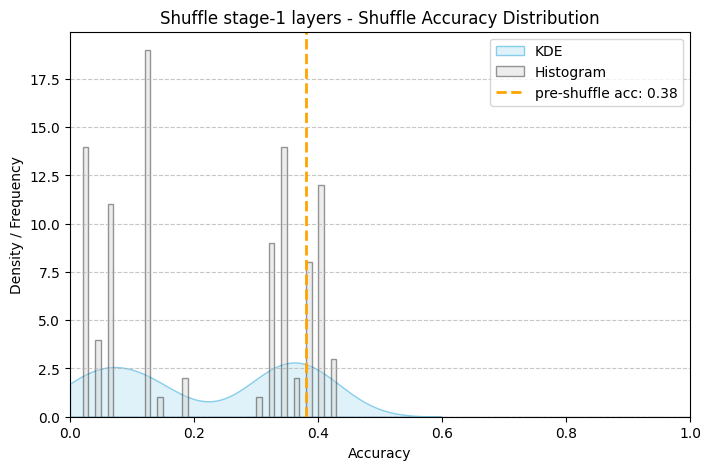

In [6]:
plot_value_distribution(shuffle_stage1_performances, special_value=acc_before, title="Shuffle stage-1 layers")

In [ ]:
stage1_shuffles

[[[0, 5, 6, 3, 1, 2, 4], [], []],
 [[2, 6, 3, 1, 0, 4, 5], [], []],
 [[0, 4, 1, 3, 2, 5, 6], [], []],
 [[5, 1, 2, 6, 3, 0, 4], [], []],
 [[2, 6, 0, 3, 4, 5, 1], [], []],
 [[2, 3, 5, 0, 6, 4, 1], [], []],
 [[4, 3, 0, 2, 6, 1, 5], [], []],
 [[5, 3, 0, 2, 1, 6, 4], [], []],
 [[3, 0, 2, 1, 6, 4, 5], [], []],
 [[1, 0, 6, 2, 3, 4, 5], [], []],
 [[2, 6, 4, 0, 1, 5, 3], [], []],
 [[0, 6, 5, 4, 2, 3, 1], [], []],
 [[0, 4, 1, 2, 6, 5, 3], [], []],
 [[5, 4, 6, 3, 2, 0, 1], [], []],
 [[3, 1, 2, 6, 4, 5, 0], [], []],
 [[6, 4, 2, 1, 3, 0, 5], [], []],
 [[0, 3, 4, 5, 6, 2, 1], [], []],
 [[0, 3, 4, 2, 1, 5, 6], [], []],
 [[5, 6, 3, 2, 4, 1, 0], [], []],
 [[3, 5, 6, 2, 1, 4, 0], [], []]]

##### Stage-1 shuffles excluding last layer

In [ ]:
# Run multiple shuffles and evaluate retrieval accuracy for each
n_shuffles = 100  # You can increase this for more robust statistics
shuffle_groups = [True, False, False]  # Shuffle all groups; change as needed
exclude_last_layer = [True, False, False]  # exlusion of last layer in groups; change as needed
limit = 50  # Number of samples to evaluate for speed

shuffle_stage1_performances, stage1_shuffles, stage1_correct_maps = evaluate_multiple_layer_shuffles(
    model_path=model_path,
    tokenizer=tokenizer,
    eval_samples=nq_eval_samples,
    device=device,
    n_shuffles=n_shuffles,
    shuffle_groups=shuffle_groups,
    exclude_last_layer=exclude_last_layer,
    verbose=False,
    limit=limit
)

print(f"\nAverage accuracy over {n_shuffles} shuffles: {sum(shuffle_stage1_performances)/len(shuffle_stage1_performances):.3f}")
print("All shuffle accuracies:", shuffle_stage1_performances)
# The 'shuffles' variable contains the FFN permutations for each run

Shuffles: 100%|██████████| 20/20 [04:16<00:00, 12.85s/it]


Average accuracy over 20 shuffles: 0.224
All shuffle accuracies: [0.4, 0.02, 0.38, 0.38, 0.32, 0.06, 0.38, 0.4, 0.02, 0.12, 0.02, 0.12, 0.36, 0.32, 0.12, 0.38, 0.06, 0.38, 0.12, 0.12]


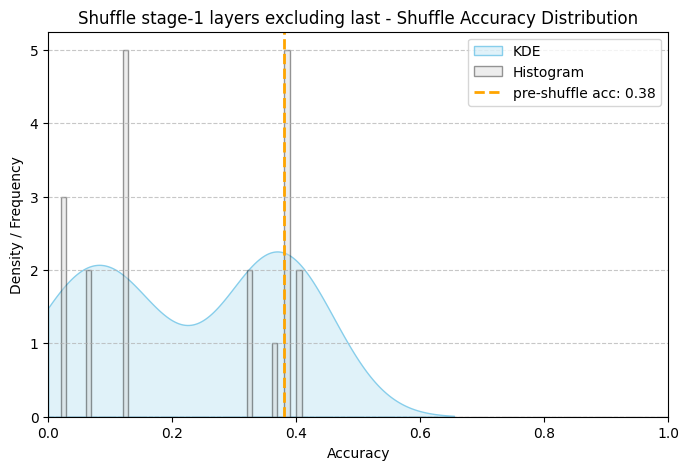

In [ ]:
plot_value_distribution(shuffle_stage1_performances, special_value=acc_before, title="Shuffle stage-1 layers excluding last")

In [ ]:
stage1_shuffles

[[[0, 5, 4, 2, 1, 3, 6], [], []],
 [[3, 4, 2, 0, 1, 5, 6], [], []],
 [[0, 3, 1, 4, 5, 2, 6], [], []],
 [[0, 3, 2, 1, 4, 5, 6], [], []],
 [[1, 3, 0, 5, 2, 4, 6], [], []],
 [[5, 4, 0, 2, 3, 1, 6], [], []],
 [[0, 2, 4, 5, 3, 1, 6], [], []],
 [[0, 4, 1, 3, 5, 2, 6], [], []],
 [[3, 0, 2, 1, 4, 5, 6], [], []],
 [[4, 1, 2, 5, 3, 0, 6], [], []],
 [[3, 0, 2, 5, 4, 1, 6], [], []],
 [[4, 3, 1, 2, 5, 0, 6], [], []],
 [[1, 4, 5, 0, 3, 2, 6], [], []],
 [[1, 3, 2, 4, 5, 0, 6], [], []],
 [[4, 5, 1, 2, 0, 3, 6], [], []],
 [[0, 3, 2, 1, 5, 4, 6], [], []],
 [[5, 0, 3, 4, 1, 2, 6], [], []],
 [[0, 3, 4, 1, 5, 2, 6], [], []],
 [[4, 5, 0, 2, 1, 3, 6], [], []],
 [[4, 0, 2, 1, 5, 3, 6], [], []]]